In [75]:
# 2枚の異なるfocus画像から奥行きを推定するプログラム
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# from tqdm import tqdm  #コマンドラインで実行するとき
from tqdm.notebook import tqdm  # jupyter で実行するとき
from models import RESNETLIKE, MyModel, MyModel_shallow

In [76]:
# リソースの指定（CPU/GPU）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [77]:
# モデル・損失関数・最適化アルゴリスムの設定
LOAD_WEIGHT = True
model = MyModel(channels=2)

PSIZE = 65
DEPTH_GAP = 100
weight_file = f"weights/weight_{PSIZE}_{DEPTH_GAP}.pth"

if LOAD_WEIGHT == True:
    # 学習済みモデルのロード
    model.load_state_dict(torch.load(weight_file))
    model.eval()

model = model.to(device)
model.eval()

MyModel(
  (conv1): Conv2d(2, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv31): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv41): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv42): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (bn64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [78]:
# 画像ペアから奥行きを推定するdataloader
class DepthEstimateData(torch.utils.data.Dataset):
    # FILEはデータが入っていたファイル、imsize = 画像サイズ、psize = パッチサイズ
    def __init__(self, IMGFILES, imsize, psize, channels, transforms):
        self.psize = psize
        self.channels = channels
        self.transforms = transforms
        
        # load file
        for fi in IMGFILES:
            img = Image.open(fi)
            img = img.convert('L')
            img = np.array(img).astype('float32')
            imgs.append(img)

        img = np.stack(imgs,axis=2)
        self.patch = []
        self.loc = []

        self.width = imsize[0]
        self.height = imsize[1]

        # 何ピクセルごとに推定するか? (高速化)
        self.STEP = 5
        
        for y in range(0,self.height-psize,self.STEP):
            for x in range(0,self.width-psize,self.STEP):
                patch = img[y:(y+psize),x:(x+psize)]
                self.patch.append(patch)
                self.loc.append([x,y])
    
    def __len__(self):
        return len(self.patch)

    def __getitem__(self, index):
        return self.transforms(self.patch[index]), self.loc[index]

In [80]:
# 対象となる画像データを読み出す (2 files)

DIR = "data/202410041747/"
psize = 65
width = 1600
height = 1200
DEPTH = 12000
files = [os.path.join(DIR,f"{DEPTH:05d}.bmp"), os.path.join(DIR,f"{DEPTH+50*DEPTH_GAP:05d}.bmp")]
print(files)
imgs = []

trans = transforms.Compose([
    transforms.ToTensor()
])

dataset = DepthEstimateData(IMGFILES=files, imsize=[width,height], psize=psize, channels=2, transforms=trans) 
# データローダーの作成
dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)

['data/202410041747/12000.bmp', 'data/202410041747/17000.bmp']


In [81]:
outputs = []

for data,loc in dataloader:
    data = data.to(device)
    output = model(data).detach().cpu().numpy()
    outputs.append(output)

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

result = np.concatenate(outputs)

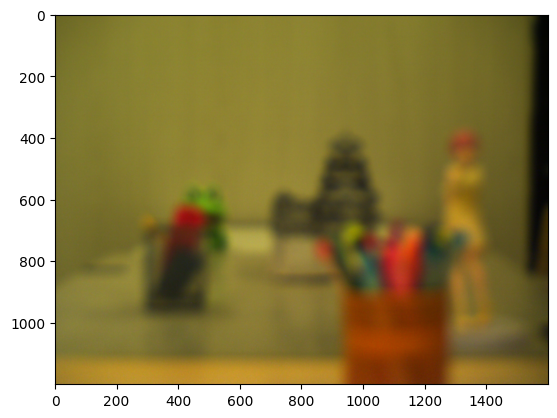

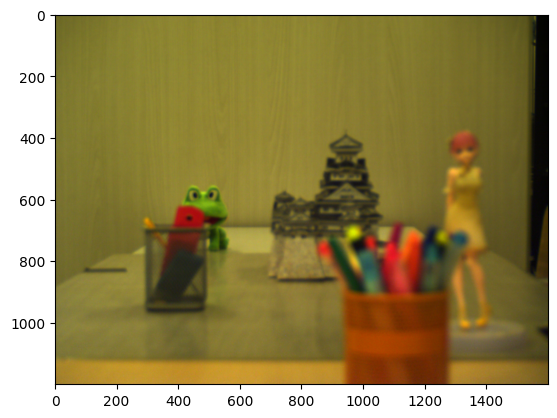

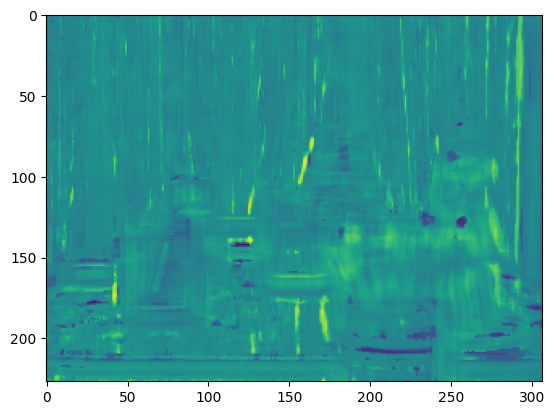

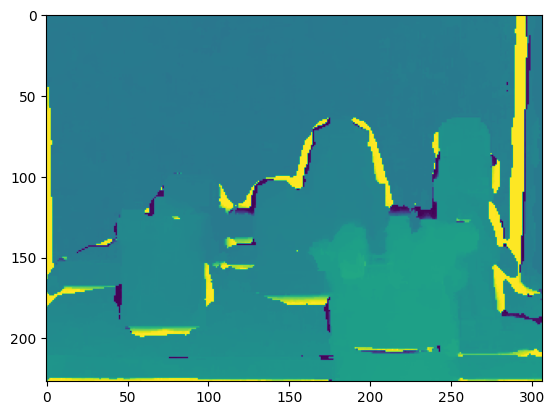

[[ 4782.3296  5130.6753  5685.4614 ...  5489.2954  5363.2036  5279.67  ]
 [ 4288.264   5183.5273  5729.6313 ...  5437.2974  5321.2026  5224.601 ]
 [ 4395.5234  5148.0386  5634.9814 ...  5607.97    5367.3394  5053.7295]
 ...
 [ 5837.3115  6290.3755  7799.029  ...  5178.9087  5007.061   5272.738 ]
 [ 7466.9146  9386.138  13568.562  ...  5527.562   5501.237   5611.2993]
 [ 7394.8335  8257.763  14469.273  ...  5209.5835  5094.704   5566.4517]]
[[ 6300.  6050.  6450. ...  6200.  6250.  6250.]
 [ 6300.  6200.  6200. ...  6150.  6150.  6250.]
 [ 6200.  6200.  6200. ...  6250.  6250.  6250.]
 ...
 [ 8300.  8300.  8300. ...  9050.  9050.  9050.]
 [ 8450.  8450. 17500. ... 10750. 10750. 10750.]
 [ 8300. 18000. 18000. ... 16300. 16300. 16300.]]


In [83]:
import pickle, cv2

# 結果画像
ws = int((width - psize)/5)
hs = int((height - psize)/5)
result2 = result.reshape([hs,ws])

# 正解画像
with open(os.path.join(DIR,"depth.pkl"),'rb') as f:
    gt = pickle.load(f)

plt.imshow(Image.open(files[0]))
plt.show()
plt.imshow(Image.open(files[1]))
plt.show()
plt.imshow(result2.astype("int16"))
plt.show()

# 結果画像をリサイズして表示
gt = gt[0:-1:5,0:-1:5].astype("float")
plt.imshow((gt-DEPTH).astype("int16"))
plt.show()

print(result2)
print(gt-DEPTH)

L1 error 2172.2721837770187


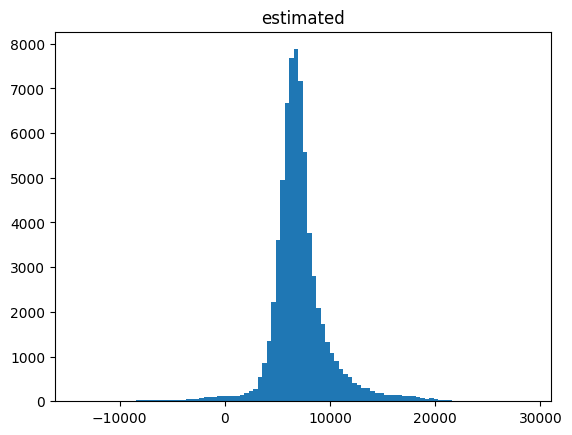

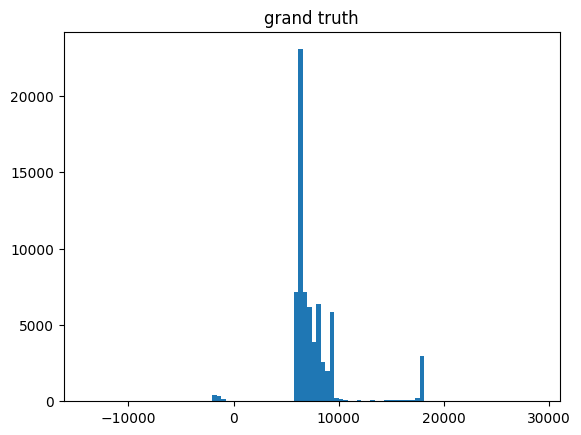

In [84]:
# エラーを計算する
err = np.linalg.norm((gt-DEPTH).flatten()-result2.flatten(),ord=1) / len(result2.flatten())
print("L1 error", err)

# ヒストグラムを表示する
#resultのヒストグラムを表示する
h = plt.hist(result2.flatten(), bins=100)
plt.title("estimated")
plt.show()
#ground truthのヒストグラムを表示する
#plt.hist(gt-DEPTH, bins=h[1])
plt.hist(gt.flatten()-DEPTH,bins=100,range=(h[1][0],h[1][-1]))
plt.title("grand truth")
plt.show()

In [85]:
with open("result2.txt", "wt") as f:
    for y in range(result2.shape[0]):
        for x in range(result2.shape[1]):
            f.write(f"{x}, {y}, {result2[y,x]*0.1}\n")

with open("gt.txt", "wt") as f:
    for y in range(gt.shape[0]):
        for x in range(gt.shape[1]):
            f.write(f"{x}, {y}, {gt[y,x]*0.1}\n")
